<a href="https://colab.research.google.com/github/vinayarkala/weather-prediction-using-machine-learning/blob/main/messina_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [7]:
# Display settings for better visualization
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

print("Starting weather prediction project for Messina, Sicily")

Starting weather prediction project for Messina, Sicily


In [8]:
# Step 1: Data Collection
# Weather data for Messina, Sicily
# We'll use the Open-Meteo Historical Weather API

def fetch_historical_weather(start_date, end_date, latitude=38.19, longitude=15.55):
    """
    Fetch historical weather data for Messina, Sicily
    """
    url = f"https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
                 "precipitation_sum", "rain_sum", "precipitation_hours",
                 "windspeed_10m_max", "windgusts_10m_max", "winddirection_10m_dominant",
                 "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
        "timezone": "Europe/Rome"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame({
            'date': pd.to_datetime(data['daily']['time']),
            'temp_max': data['daily']['temperature_2m_max'],
            'temp_min': data['daily']['temperature_2m_min'],
            'temp_mean': data['daily']['temperature_2m_mean'],
            'precipitation': data['daily']['precipitation_sum'],
            'rain': data['daily']['rain_sum'],
            'precip_hours': data['daily']['precipitation_hours'],
            'wind_speed': data['daily']['windspeed_10m_max'],
            'wind_gusts': data['daily']['windgusts_10m_max'],
            'wind_direction': data['daily']['winddirection_10m_dominant'],
            'radiation': data['daily']['shortwave_radiation_sum'],
            'evapotranspiration': data['daily']['et0_fao_evapotranspiration']
        })
        return df
    else:
        print(f"Failed to fetch data: {response.status_code}")
        print(response.text)
        return None

In [9]:
# Get training data for the past 15 years
end_date = "2025-05-05"
start_date = "2010-01-01"  # 15 years of data
print(f"Fetching historical weather data from {start_date} to {end_date}...")

df = fetch_historical_weather(start_date, end_date)

if df is not None:
    print(f"Successfully retrieved {len(df)} days of historical weather data")
    print(df.head())

    # Save the raw data
    df.to_csv('messina_weather_data_raw.csv', index=False)

Fetching historical weather data from 2010-01-01 to 2025-05-05...
Successfully retrieved 5604 days of historical weather data
        date  temp_max  temp_min  temp_mean  precipitation  rain  \
0 2010-01-01      17.1      11.7       14.4            1.0   1.0   
1 2010-01-02      14.4      11.9       13.1           11.1  11.1   
2 2010-01-03      12.9       9.3       11.6            2.4   2.4   
3 2010-01-04      13.6       6.8       11.1            0.0   0.0   
4 2010-01-05      16.8      12.4       14.2            0.0   0.0   

   precip_hours  wind_speed  wind_gusts  wind_direction  radiation  \
0           6.0        37.2        59.0             270       8.22   
1          19.0        42.0        70.6             279       6.98   
2           6.0        41.3        71.3             302       4.97   
3           0.0        30.9        50.8             156       5.87   
4           0.0        30.6        50.8             163       8.75   

   evapotranspiration  
0                2.4

In [10]:
    # Step 2: Data Preprocessing

    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_values)

        # Fill missing values (if any)
    df = df.fillna(method='ffill')  # Forward fill



Missing values in each column:
date                  0
temp_max              0
temp_min              0
temp_mean             0
precipitation         0
rain                  0
precip_hours          0
wind_speed            0
wind_gusts            0
wind_direction        0
radiation             0
evapotranspiration    0
dtype: int64


In [11]:

    # Feature Engineering
    # Extract date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['is_summer'] = ((df['month'] >= 6) & (df['month'] <= 8)).astype(int)
    df['is_winter'] = ((df['month'] >= 12) | (df['month'] <= 2)).astype(int)

In [18]:
    # Create rolling window features
    for window in [3, 7, 14]:
        df[f'temp_mean_rolling_{window}'] = df['temp_mean'].rolling(window=window).mean()
        df[f'precip_rolling_{window}'] = df['precipitation'].rolling(window=window).mean()
        df[f'wind_rolling_{window}'] = df['wind_speed'].rolling(window=window).mean()

    # Drop rows with NaN values after creating lag features
    df = df.dropna()


Creating exploratory visualizations of the historical data...


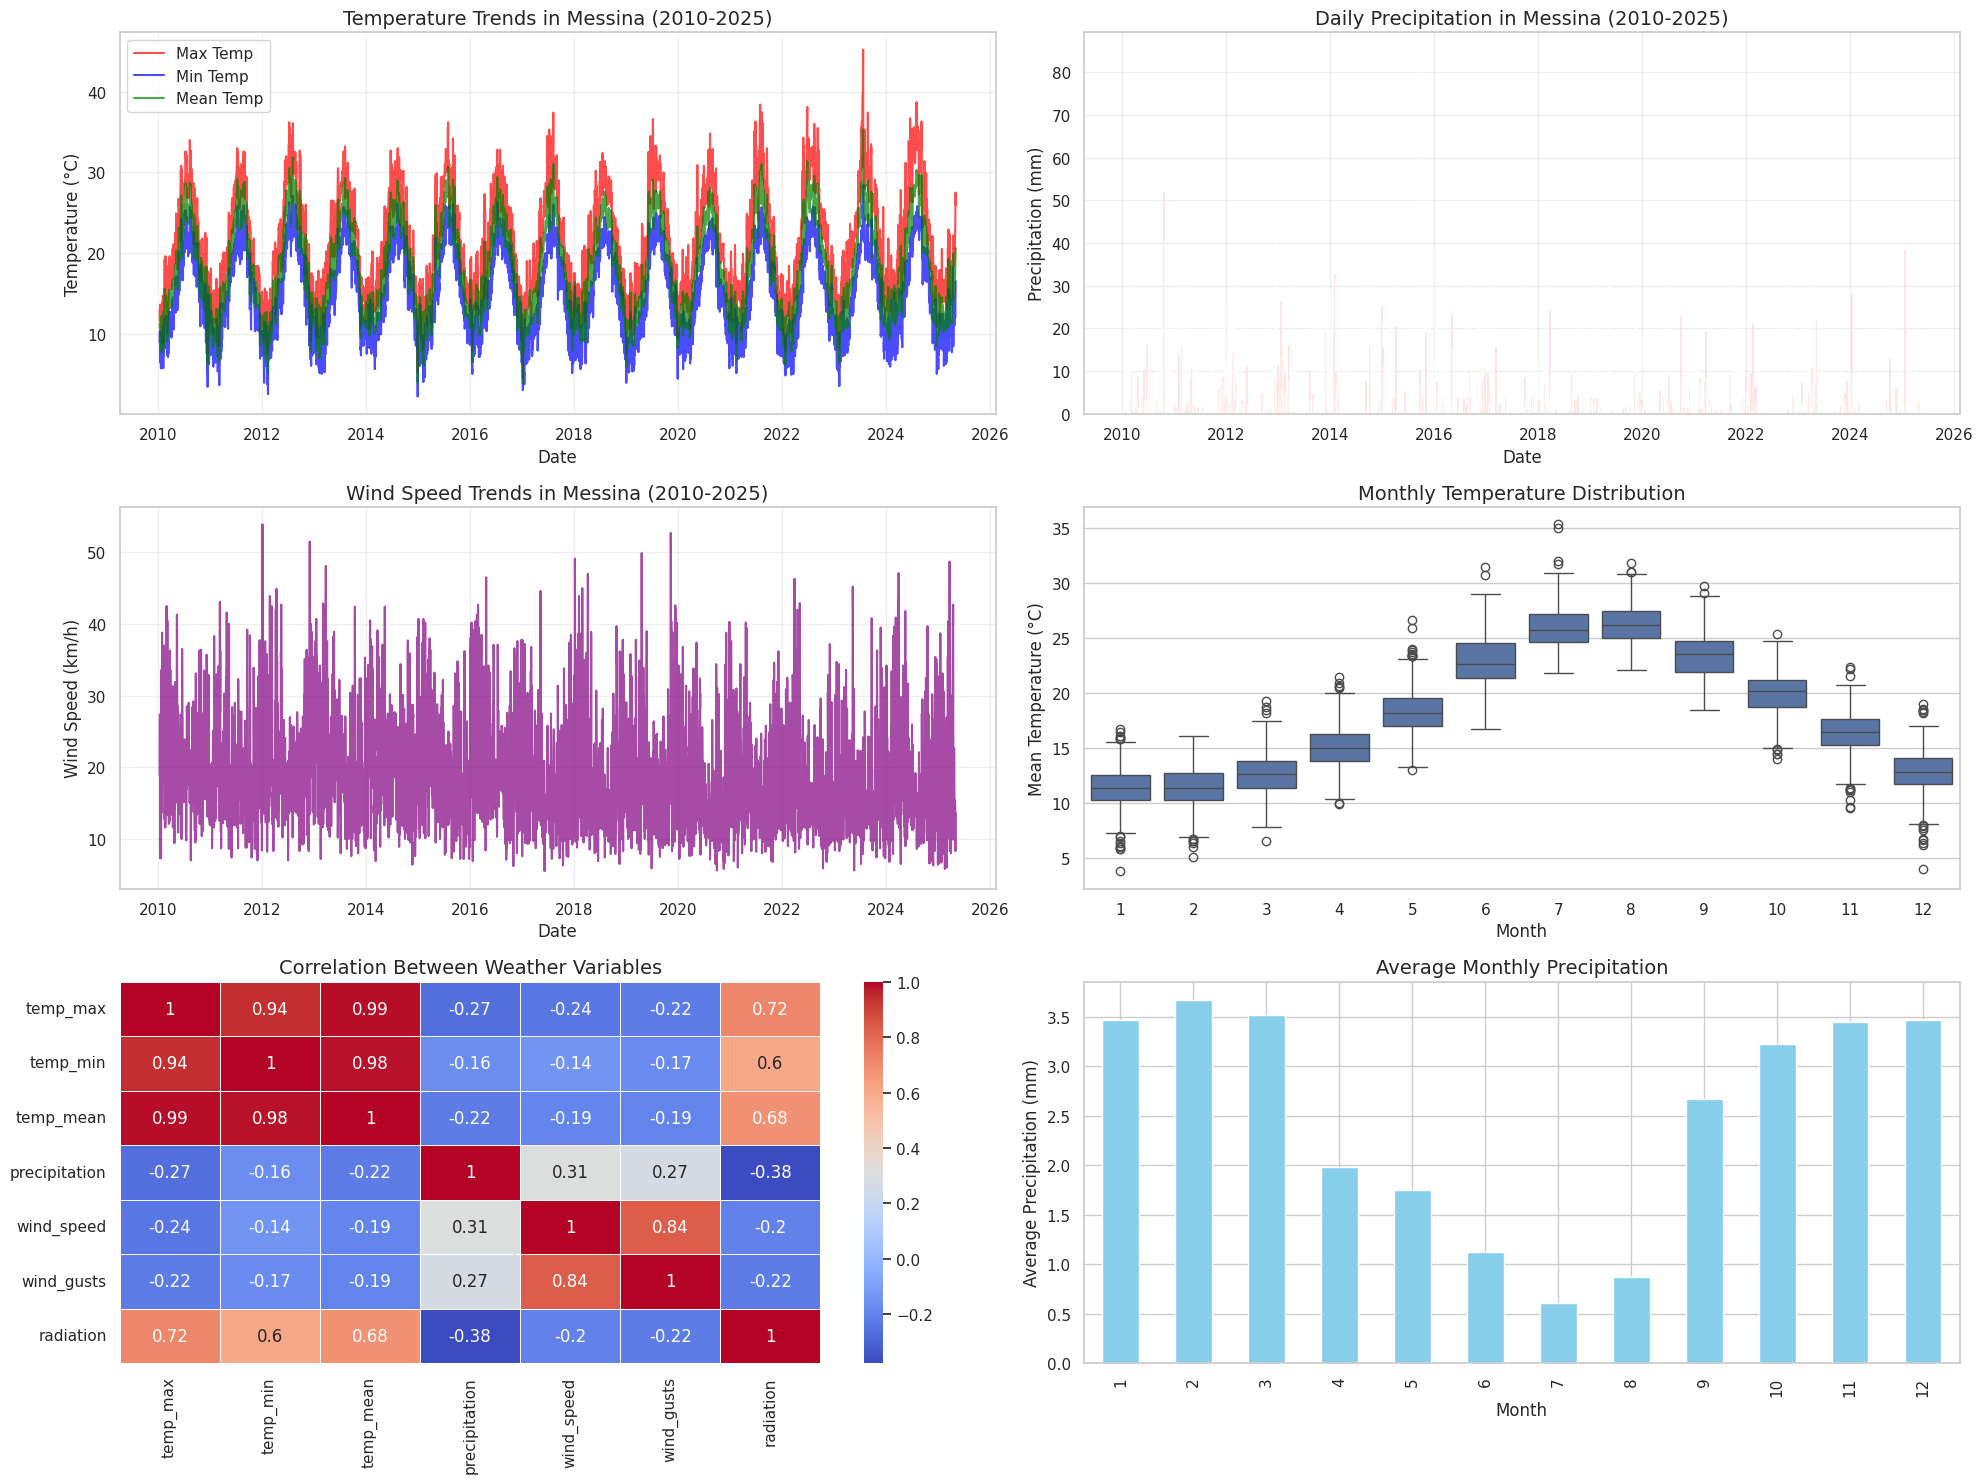

In [19]:
    # Step 3: Data Visualization

    print("\nCreating exploratory visualizations of the historical data...")

    # Set up a figure for our visualizations
    plt.figure(figsize=(20, 15))

    # 1. Temperature trends over time
    plt.subplot(3, 2, 1)
    plt.plot(df['date'], df['temp_max'], label='Max Temp', color='red', alpha=0.7)
    plt.plot(df['date'], df['temp_min'], label='Min Temp', color='blue', alpha=0.7)
    plt.plot(df['date'], df['temp_mean'], label='Mean Temp', color='green', alpha=0.7)
    plt.title('Temperature Trends in Messina (2010-2025)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Precipitation patterns
    plt.subplot(3, 2, 2)
    plt.bar(df['date'], df['precipitation'], color='red', alpha=0.7)
    plt.title('Daily Precipitation in Messina (2010-2025)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Precipitation (mm)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 3. Wind speed trends
    plt.subplot(3, 2, 3)
    plt.plot(df['date'], df['wind_speed'], color='purple', alpha=0.7)
    plt.title('Wind Speed Trends in Messina (2010-2025)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Wind Speed (km/h)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 4. Monthly temperature boxplot
    plt.subplot(3, 2, 4)
    sns.boxplot(x=df['month'], y=df['temp_mean'])
    plt.title('Monthly Temperature Distribution', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Mean Temperature (°C)', fontsize=12)

    # 5. Correlation heatmap for key variables
    plt.subplot(3, 2, 5)
    corr_cols = ['temp_max', 'temp_min', 'temp_mean', 'precipitation',
                'wind_speed', 'wind_gusts', 'radiation']
    corr_matrix = df[corr_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Between Weather Variables', fontsize=14)

    # 6. Monthly precipitation patterns
    plt.subplot(3, 2, 6)
    monthly_precip = df.groupby('month')['precipitation'].mean()
    monthly_precip.plot(kind='bar', color='skyblue')
    plt.title('Average Monthly Precipitation', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Precipitation (mm)', fontsize=12)

    plt.tight_layout()
    plt.savefig('messina_historical_weather_viz.png', dpi=300)
    plt.show()


Performing seasonal decomposition analysis...


<Figure size 1200x1000 with 0 Axes>

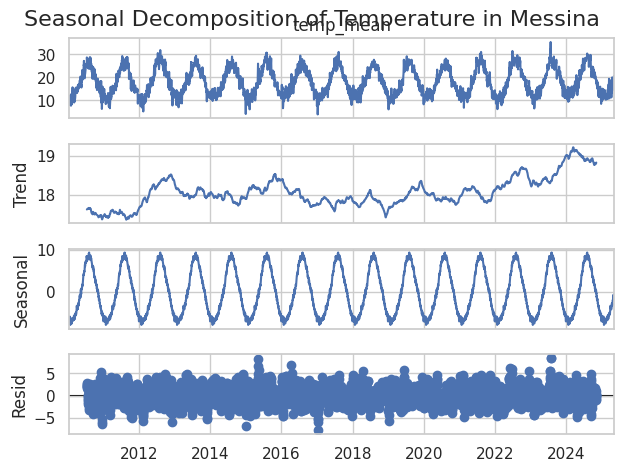

In [20]:
    # Seasonal decomposition visualization
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Resample data to ensure regular time series (if needed)
    ts_data = df.set_index('date')['temp_mean'].resample('D').mean().fillna(method='ffill')

    # Perform seasonal decomposition
    print("\nPerforming seasonal decomposition analysis...")
    result = seasonal_decompose(ts_data, model='additive', period=365)

    plt.figure(figsize=(12, 10))
    result.plot()
    plt.suptitle('Seasonal Decomposition of Temperature in Messina', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('messina_seasonal_decomposition.png', dpi=300)
    plt.show()

In [21]:
    # Step 4: Feature Selection and Preparation

    print("\nPreparing features for model training...")

    # Select features for prediction
    features = ['temp_max', 'temp_min', 'temp_mean', 'precipitation', 'rain',
               'wind_speed', 'radiation', 'month', 'day', 'dayofyear', 'is_summer', 'is_winter',
               'temp_mean_lag_1', 'temp_mean_lag_2', 'temp_mean_lag_3', 'temp_mean_lag_7',
               'precip_lag_1', 'precip_lag_2', 'precip_lag_3', 'precip_lag_7',
               'temp_mean_rolling_3', 'temp_mean_rolling_7', 'temp_mean_rolling_14',
               'precip_rolling_7', 'wind_rolling_7']

    # Target variables - we'll predict these separately
    target_variables = ['temp_max', 'temp_min', 'temp_mean', 'precipitation', 'wind_speed']

    # Function to prepare data for LSTM model
    def prepare_lstm_data(data, features, target, sequence_length=14):
        """Prepare data for LSTM model with sequence_length days of history"""
        X, y = [], []

        for i in range(len(data) - sequence_length):
            X.append(data[features].iloc[i:i+sequence_length].values)
            y.append(data[target].iloc[i+sequence_length])

        return np.array(X), np.array(y)

    # Create training and test datasets for each target variable
    # We'll use 80% for training and 20% for testing
    train_size = int(len(df) * 0.8)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    print(f"Train data size: {len(train_data)} days")
    print(f"Test data size: {len(test_data)} days")

    # Normalize the data
    scaler_dict = {}
    train_scaled = train_data.copy()
    test_scaled = test_data.copy()

    for column in features + target_variables:
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled[column] = scaler.fit_transform(train_data[[column]])
        test_scaled[column] = scaler.transform(test_data[[column]])
        scaler_dict[column] = scaler



Preparing features for model training...
Train data size: 4472 days
Test data size: 1119 days


In [22]:
    # Function to build and train LSTM model
    def build_train_lstm_model(X_train, y_train, X_test, y_test):
        """Build and train an LSTM model"""
        # Define the LSTM model
        model = Sequential()

        # Add LSTM layers
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=25))
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Early stopping to prevent overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        return model, history


Training LSTM models for each weather variable...

Training model for temp_max...
X_train shape: (4458, 14, 25), y_train shape: (4458,)
X_test shape: (1105, 14, 25), y_test shape: (1105,)
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0222 - val_loss: 0.0053
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 10/50
140/140 ━━━━━━━━

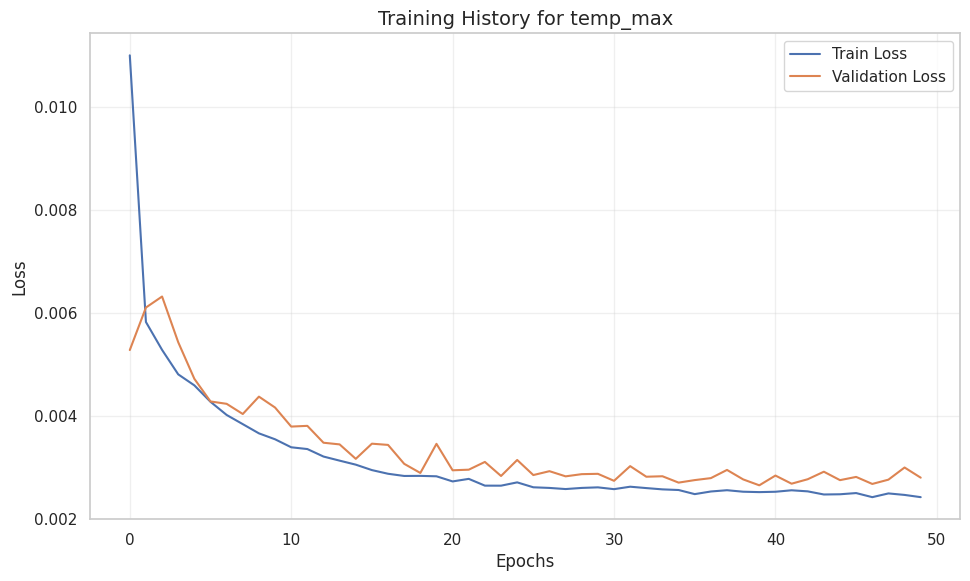


Training model for temp_min...
X_train shape: (4458, 14, 25), y_train shape: (4458,)
X_test shape: (1105, 14, 25), y_test shape: (1105,)
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0253 - val_loss: 0.0054
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0043 - val_loss

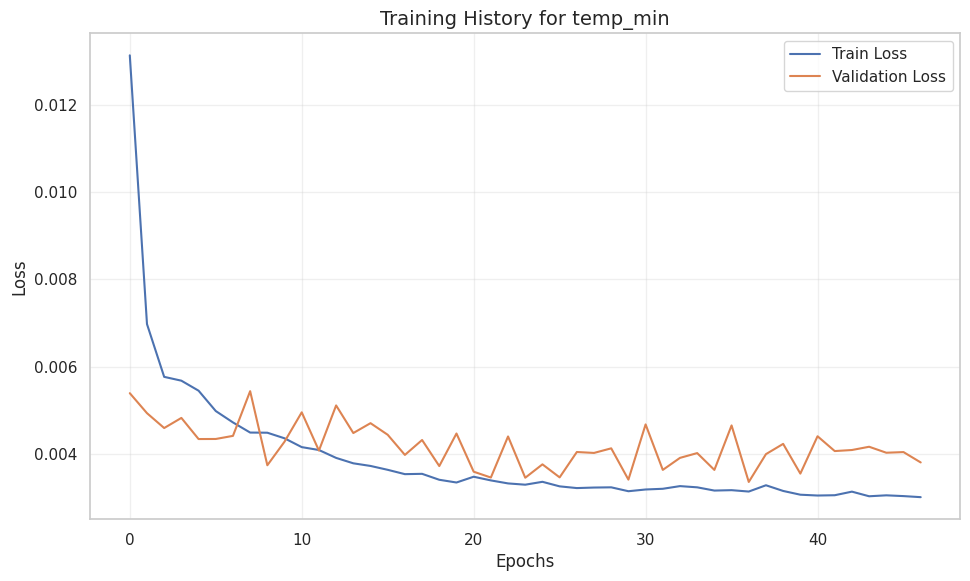


Training model for temp_mean...
X_train shape: (4458, 14, 25), y_train shape: (4458,)
X_test shape: (1105, 14, 25), y_test shape: (1105,)
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0169 - val_loss: 0.0040
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_los

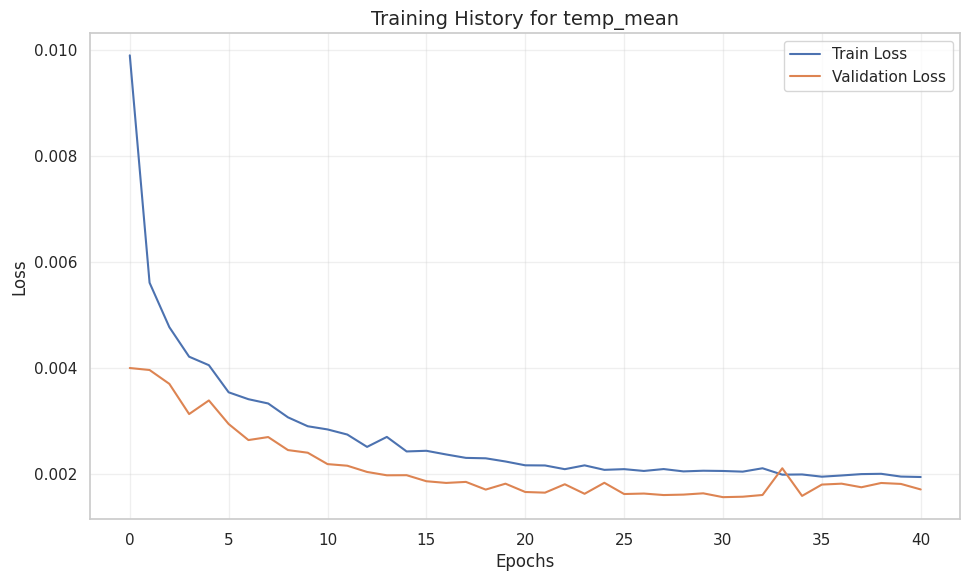


Training model for precipitation...
X_train shape: (4458, 14, 25), y_train shape: (4458,)
X_test shape: (1105, 14, 25), y_test shape: (1105,)
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0040 - val

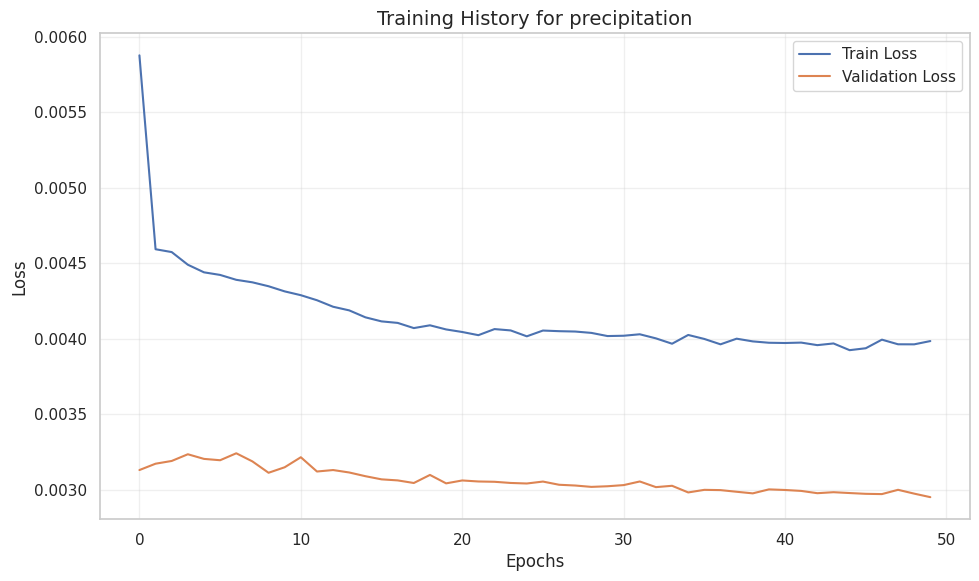


Training model for wind_speed...
X_train shape: (4458, 14, 25), y_train shape: (4458,)
X_test shape: (1105, 14, 25), y_test shape: (1105,)
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0282 - val_loss: 0.0203
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0213 - val_loss: 0.0199
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0211 - val_loss: 0.0198
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0202 - val_loss: 0.0191
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0195 - val_loss: 0.0185
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0184 - val_loss: 0.0169
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0178 - val_loss: 0.0162
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0177 - val_lo

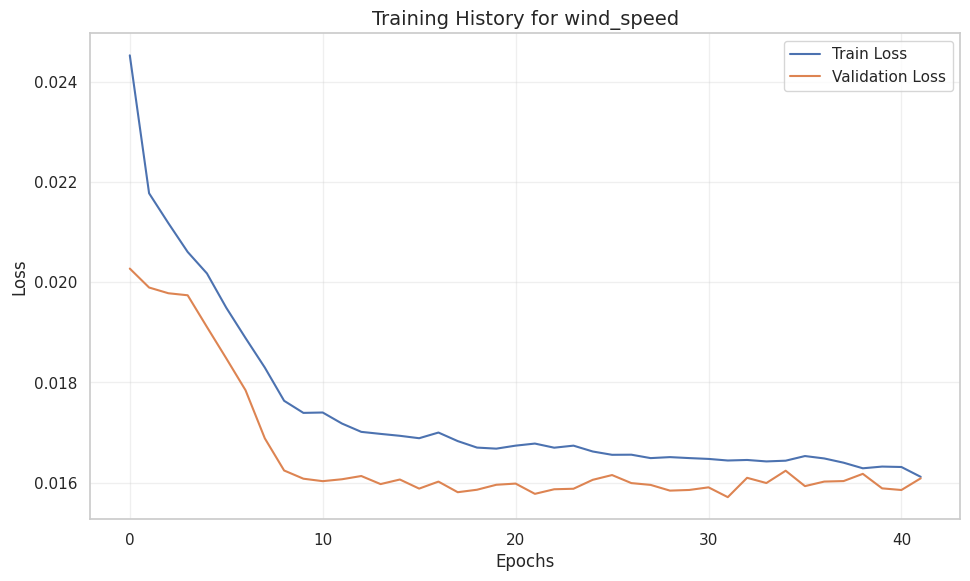

In [23]:
    # Dictionary to store models and predictions
    models = {}
    histories = {}
    predictions = {}
    test_predictions = {}

    # Train models for each target variable
    print("\nTraining LSTM models for each weather variable...")

    sequence_length = 14  # Use 14 days of history to predict next day

    for target in target_variables:
        print(f"\nTraining model for {target}...")

        # Prepare sequence data for LSTM
        X_train, y_train = prepare_lstm_data(train_scaled, features, target, sequence_length)
        X_test, y_test = prepare_lstm_data(test_scaled, features, target, sequence_length)

        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        # Build and train the model
        model, history = build_train_lstm_model(X_train, y_train, X_test, y_test)

        # Store the model and history
        models[target] = model
        histories[target] = history

        # Make predictions on test data
        test_pred = model.predict(X_test)

        # Inverse transform to get actual values
        test_pred_inv = scaler_dict[target].inverse_transform(test_pred)
        y_test_inv = scaler_dict[target].inverse_transform(y_test.reshape(-1, 1))

        # Store predictions
        test_predictions[target] = {
            'true': y_test_inv.flatten(),
            'pred': test_pred_inv.flatten(),
            'dates': test_data['date'].iloc[sequence_length:].values
        }

        # Calculate error metrics
        mse = mean_squared_error(y_test_inv, test_pred_inv)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_inv, test_pred_inv)

        print(f"{target} - Test RMSE: {rmse:.2f}, MAE: {mae:.2f}")

        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Training History for {target}', fontsize=14)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'messina_{target}_training_history.png', dpi=300)
        plt.show()


Visualizing test predictions...


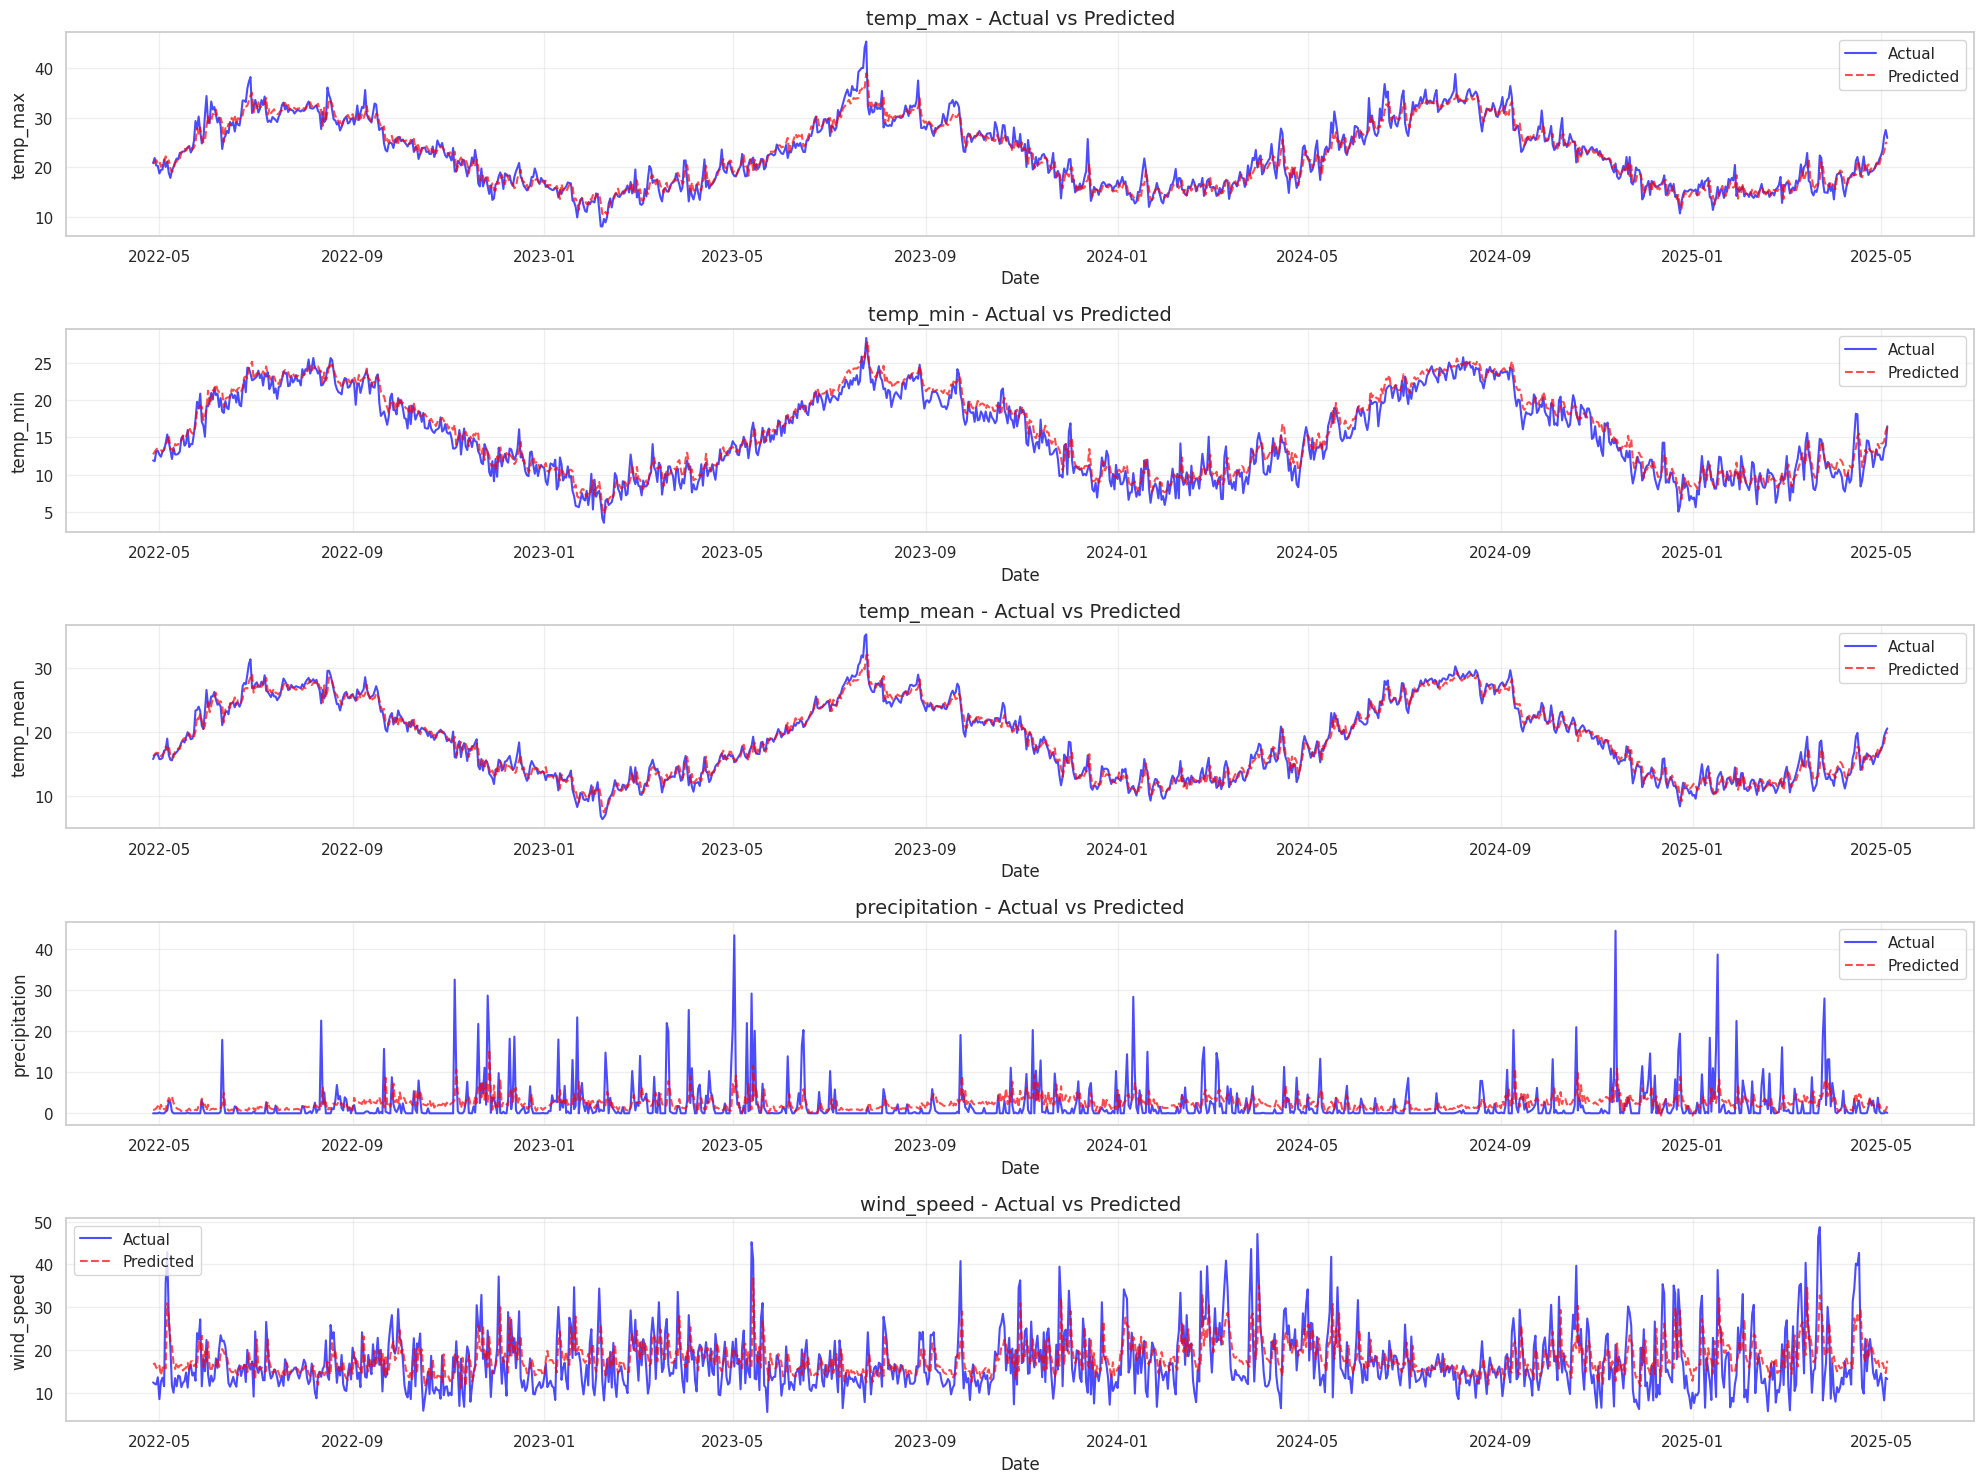

In [24]:
    # Step 5: Visualize Test Predictions

    print("\nVisualizing test predictions...")

    plt.figure(figsize=(20, 15))

    for i, target in enumerate(target_variables):
        plt.subplot(len(target_variables), 1, i+1)

        true_vals = test_predictions[target]['true']
        pred_vals = test_predictions[target]['pred']
        dates = test_predictions[target]['dates']

        # FIX: Handle NaN values in visualization
        valid_idx = ~np.isnan(true_vals) & ~np.isnan(pred_vals)

        plt.plot(dates[valid_idx], true_vals[valid_idx], label='Actual', color='blue', alpha=0.7)
        plt.plot(dates[valid_idx], pred_vals[valid_idx], label='Predicted', color='red', linestyle='--', alpha=0.7)

        plt.title(f'{target} - Actual vs Predicted', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(target, fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('messina_test_predictions.png', dpi=300)
    plt.show()

In [25]:
    # Step 6: Make Future Predictions (May 6-19, 2025)

    print("\nGenerating predictions for May 6-19, 2025...")

    # Prepare the most recent data for prediction
    last_sequence = df.iloc[-sequence_length:].copy()

    # Create empty dataframe for predictions
    future_dates = pd.date_range(start='2025-05-06', end='2025-05-19', freq='D')
    future_predictions = pd.DataFrame(index=future_dates)

    # Generate predictions for each day
    for target in target_variables:
        # Initialize list to store predictions
        target_predictions = []

        # Make a copy of the last sequence for rolling predictions
        prediction_sequence = last_sequence.copy()

        # For each day in the prediction period
        for i in range(len(future_dates)):
            # Prepare the input data
            input_data = prediction_sequence[features].values

            # Scale the input data
            for j, feat in enumerate(features):
                input_data[:, j] = scaler_dict[feat].transform(prediction_sequence[[feat]]).flatten()

            # Reshape for LSTM input
            input_data = input_data.reshape(1, sequence_length, len(features))

            # Make prediction
            scaled_pred = models[target].predict(input_data)

            # Inverse transform to get actual value
            actual_pred = scaler_dict[target].inverse_transform(scaled_pred)[0, 0]

            # Store prediction
            target_predictions.append(actual_pred)

            # Create next sequence by dropping oldest day and adding prediction day
            new_day = prediction_sequence.iloc[-1:].copy()
            new_day['date'] = future_dates[i]
            new_day[target] = actual_pred

            # Update date features for the new day
            new_day['year'] = new_day['date'].dt.year
            new_day['month'] = new_day['date'].dt.month
            new_day['day'] = new_day['date'].dt.day
            new_day['dayofweek'] = new_day['date'].dt.dayofweek
            new_day['dayofyear'] = new_day['date'].dt.dayofyear
            new_day['is_summer'] = ((new_day['month'] >= 6) & (new_day['month'] <= 8)).astype(int)
            new_day['is_winter'] = ((new_day['month'] >= 12) | (new_day['month'] <= 2)).astype(int)

            # FIX: Make sure to copy over all other features from the previous day
            for col in prediction_sequence.columns:
                if col not in new_day.columns and col != 'date':
                    new_day[col] = prediction_sequence.iloc[-1][col]

            # Update lag features for the new day
            if i > 0:  # Only update lag features after the first prediction
                new_day['temp_mean_lag_1'] = prediction_sequence.iloc[-1]['temp_mean']
                new_day['precip_lag_1'] = prediction_sequence.iloc[-1]['precipitation']
                new_day['wind_speed_lag_1'] = prediction_sequence.iloc[-1]['wind_speed']

                if i > 1:
                    new_day['temp_mean_lag_2'] = prediction_sequence.iloc[-2]['temp_mean']
                    new_day['precip_lag_2'] = prediction_sequence.iloc[-2]['precipitation']
                    new_day['wind_speed_lag_2'] = prediction_sequence.iloc[-2]['wind_speed']

                if i > 2:
                    new_day['temp_mean_lag_3'] = prediction_sequence.iloc[-3]['temp_mean']
                    new_day['precip_lag_3'] = prediction_sequence.iloc[-3]['precipitation']
                    new_day['wind_speed_lag_3'] = prediction_sequence.iloc[-3]['wind_speed']

            # Update rolling mean features
            # We'll use a simplified approach for the rolling features in future predictions
            window_sizes = [3, 7, 14]
            for window in window_sizes:
                if i + 1 >= window:
                    # Use the most recent window days (including the new prediction)
                    temp_vals = list(prediction_sequence['temp_mean'].iloc[-(window-1):]) + [actual_pred if target == 'temp_mean' else prediction_sequence.iloc[-1]['temp_mean']]
                    precip_vals = list(prediction_sequence['precipitation'].iloc[-(window-1):]) + [actual_pred if target == 'precipitation' else prediction_sequence.iloc[-1]['precipitation']]
                    wind_vals = list(prediction_sequence['wind_speed'].iloc[-(window-1):]) + [actual_pred if target == 'wind_speed' else prediction_sequence.iloc[-1]['wind_speed']]

                    new_day[f'temp_mean_rolling_{window}'] = np.mean(temp_vals)
                    new_day[f'precip_rolling_{window}'] = np.mean(precip_vals)
                    new_day[f'wind_rolling_{window}'] = np.mean(wind_vals)
                else:
                    # Not enough days for a full window, use what we have
                    new_day[f'temp_mean_rolling_{window}'] = prediction_sequence[f'temp_mean_rolling_{window}'].iloc[-1]
                    new_day[f'precip_rolling_{window}'] = prediction_sequence[f'precip_rolling_{window}'].iloc[-1]
                    new_day[f'wind_rolling_{window}'] = prediction_sequence[f'wind_rolling_{window}'].iloc[-1]

            # Update prediction sequence for next iteration
            prediction_sequence = pd.concat([prediction_sequence.iloc[1:], new_day])

        # Add predictions to future_predictions dataframe
        future_predictions[target] = target_predictions

    # Save predictions to CSV
    future_predictions.to_csv('messina_weather_predictions_may_2025.csv')

    print("\nFuture predictions for May 6-19, 2025:")
    print(future_predictions)


Generating predictions for May 6-19, 2025...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 


Visualizing future predictions...


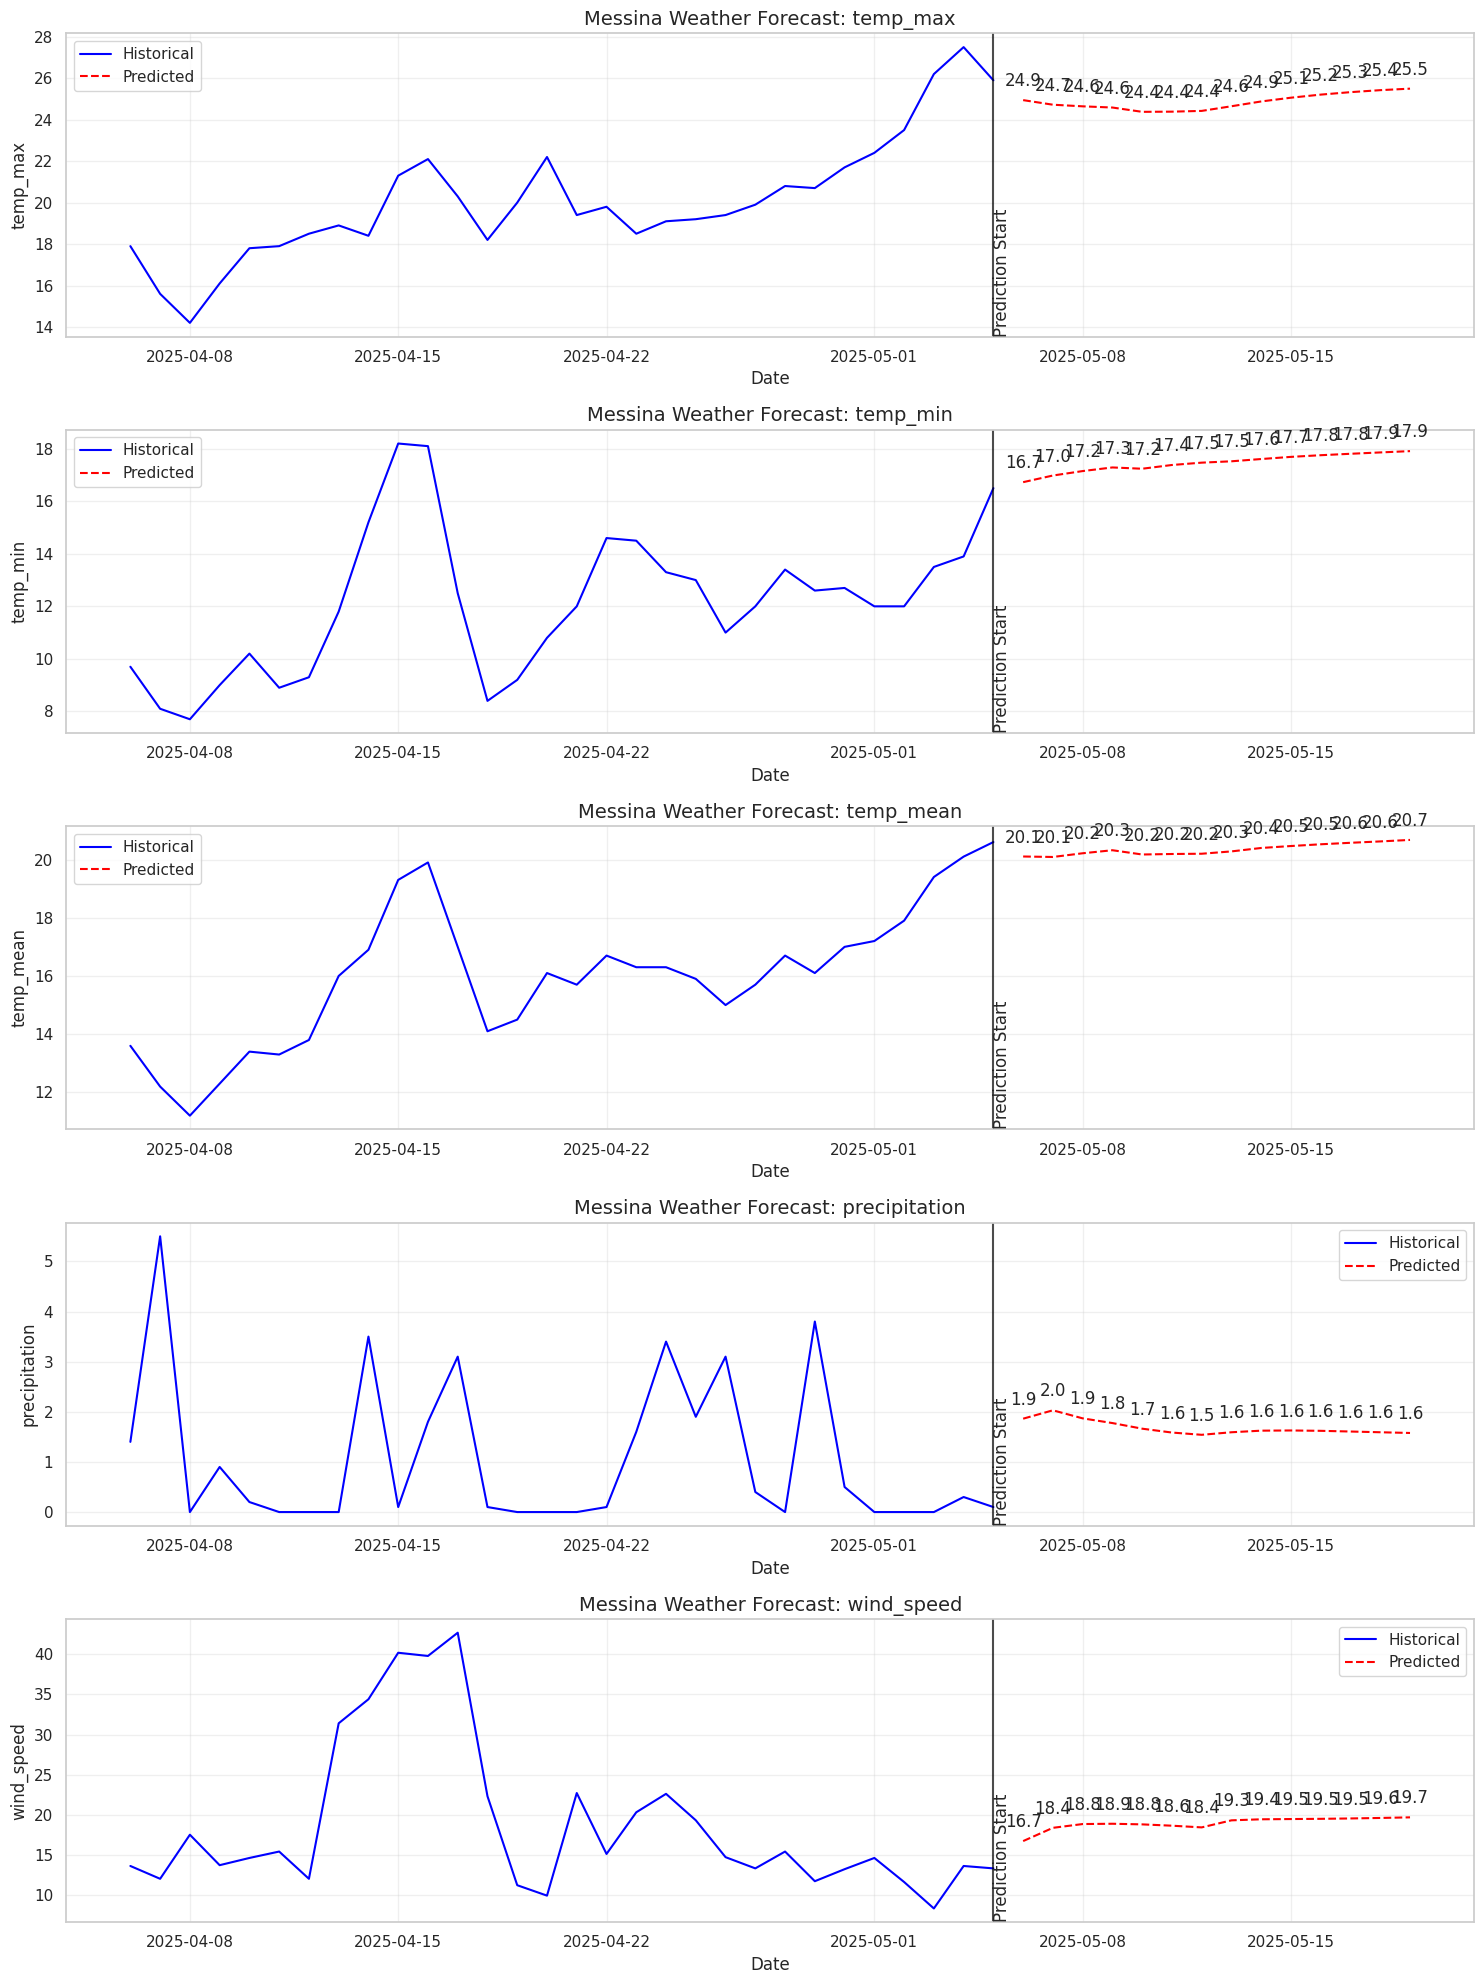

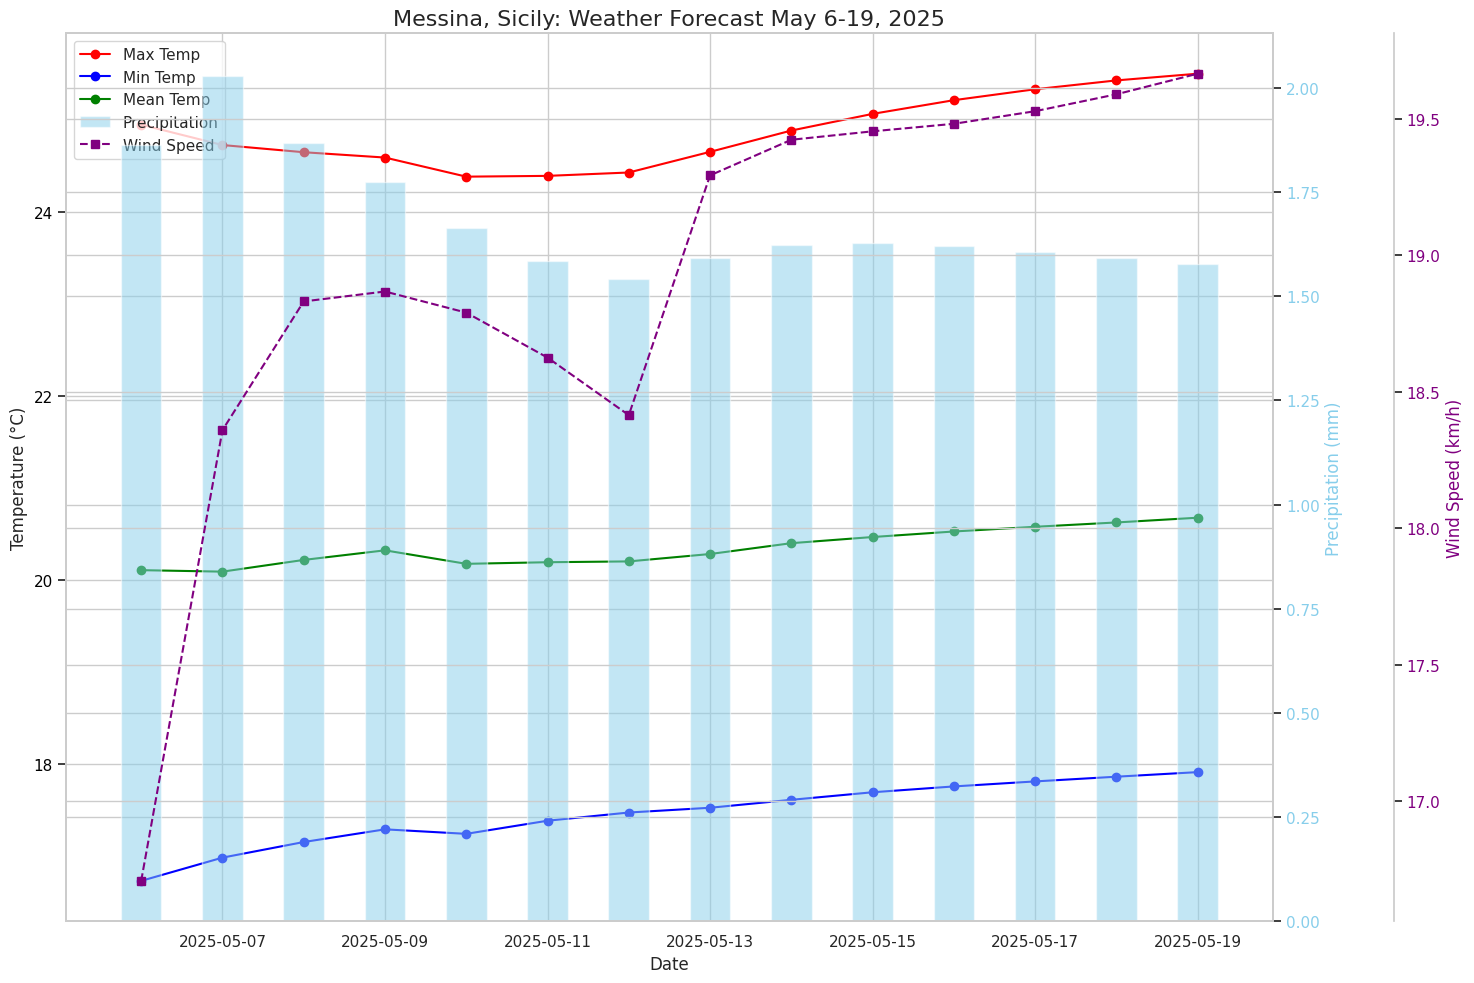

In [26]:
    # Step 7: Visualize Future Predictions

    print("\nVisualizing future predictions...")

    # Plot historical data and future predictions
    plt.figure(figsize=(15, 20))

    for i, target in enumerate(target_variables):
        plt.subplot(len(target_variables), 1, i+1)

        # Plot historical data (last 30 days)
        historical_dates = df['date'].iloc[-30:]
        historical_values = df[target].iloc[-30:]
        plt.plot(historical_dates, historical_values, label='Historical', color='blue')

        # Plot future predictions
        plt.plot(future_predictions.index, future_predictions[target],
                label='Predicted', color='red', linestyle='--')

        # Add a vertical line to separate historical from predicted
        plt.axvline(x=pd.to_datetime('2025-05-05'), color='black', linestyle='-', alpha=0.7)
        plt.text(pd.to_datetime('2025-05-05'), plt.ylim()[0], 'Prediction Start',
                rotation=90, verticalalignment='bottom')

        plt.title(f'Messina Weather Forecast: {target}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(target, fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Annotate predicted values
        for date, value in zip(future_predictions.index, future_predictions[target]):
            plt.annotate(f'{value:.1f}', (date, value),
                        textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.savefig('messina_future_weather_predictions.png', dpi=300)
    plt.show()

    # Create a comprehensive visualization of all predictions
    plt.figure(figsize=(15, 10))

    # Temperature subplot (primary y-axis)
    ax1 = plt.subplot(111)

    # Plot temperature predictions
    ax1.plot(future_predictions.index, future_predictions['temp_max'],
            label='Max Temp', color='red', marker='o')
    ax1.plot(future_predictions.index, future_predictions['temp_min'],
            label='Min Temp', color='blue', marker='o')
    ax1.plot(future_predictions.index, future_predictions['temp_mean'],
            label='Mean Temp', color='green', marker='o')

    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='black')

    # Precipitation and wind subplot (secondary y-axes)
    ax2 = ax1.twinx()
    ax2.bar(future_predictions.index, future_predictions['precipitation'],
           label='Precipitation', color='skyblue', alpha=0.5, width=0.5)
    ax2.set_ylabel('Precipitation (mm)', fontsize=12, color='skyblue')
    ax2.tick_params(axis='y', labelcolor='skyblue')

    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.plot(future_predictions.index, future_predictions['wind_speed'],
            label='Wind Speed', color='purple', linestyle='--', marker='s')
    ax3.set_ylabel('Wind Speed (km/h)', fontsize=12, color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    # Title and legend
    plt.title('Messina, Sicily: Weather Forecast May 6-19, 2025', fontsize=16)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

    plt.tight_layout()
    plt.savefig('messina_comprehensive_forecast.png', dpi=300)
    plt.show()